In [1]:
from skimage.color import rgb2gray
import numpy as np
import cv2
import matplotlib.pyplot as plt
#win=cv2.imread("W3_W3_vid_06-01-2020_10am_578_4_1241.png")
win=cv2.imread("W2_W2_vid_19-03-2020_12PM_1_578_258_167.png")
from skimage.color import rgb2gray
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from skimage import morphology
import numpy as np
import skimage
import numpy as np
from matplotlib import colors
from scipy.spatial import cKDTree as KDTree
from skimage.color import rgb2gray
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from skimage import morphology
import numpy as np
import skimage
#rom scipy.misc import face
#function to select/get appropriate cluster
def selection(img):
   # print("se")
    REDUCED_COLOR_SPACE = True

    use_colors = {k: colors.cnames[k] for k in ['black', 'darkgrey','lightslategrey','darkslategray','silver','burlywood','darksalmon','darkslateblue']}

    # translate hexstring to RGB tuple
    named_colors = {k: tuple(map(int, (v[1:3], v[3:5], v[5:7]), 3*(16,)))
                    for k, v in use_colors.items()}
    ncol = len(named_colors)
    #print(ncol)

    # make an array containing the RGB values 
    color_tuples = list(named_colors.values())
    #color_tuples.append(no_match)
    color_tuples = np.array(color_tuples)

    color_names = list(named_colors)
    # build tree
    tree = KDTree(color_tuples[:-1])
    # tolerance for color match `inf` means use best match no matter how
    # bad it may be
    tolerance = np.inf
    # find closest color in tree for each pixel in picture
    dist, idx = tree.query(img, distance_upper_bound=tolerance)
    # count and reattach names
    counts = dict(zip(color_names, np.bincount(idx.ravel(), None, ncol+1)))
    #print(counts)
    if counts['darksalmon']>1000:
        #print("return true")
        return True
    else:
        #print("return fasle")
        return False
#function to get small window co-ordinates
def get_small_window(mask,dy):
    #for small window
    thresh = cv2.adaptiveThreshold(mask,50,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
    wintemp = thresh * (mask!=255)
    cnts,h = cv2.findContours(wintemp, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    smallw=[]
    #dy=win.copy()
    h = h[0]
    
    for component in zip(cnts, h):
        currentContour = component[0]
        currentHierarchy = component[1]
        x,y,w,h = cv2.boundingRect(currentContour)
        if currentHierarchy[2] < 0 and w>10:#gets only child contour
            w=20
            h=140
            smallw.append([x,y,w,h])
            cv2.rectangle(dy,(x,y),(x+w,y+h),(0,0,255),3)
        #elif currentHierarchy[3] < 0:
            # these are the outermost parent components
            #cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),3)
    print("small win",smallw)
    return dy,smallw

#plt.imshow(dy)
#get outer window with mask

def get_big_window(mask,windows_img,yy):
    bluecnts,h = cv2.findContours(mask.copy(),
                                  cv2.RETR_EXTERNAL,
                                  cv2.CHAIN_APPROX_SIMPLE)
    #cnts = [list(x) for x in set(tuple(x) for x in bluecnts)]
    bigw=[]
    dy=windows_img.copy()
    h = h[0]
    for component in zip(bluecnts, h):
        currentContour = component[0]
        currentHierarchy = component[1]
        x,y,w,h = cv2.boundingRect(currentContour)
        #print( x,y,w,h,"hh",currentHierarchy[3],currentHierarchy[2],currentHierarchy[1],currentHierarchy[0])
        if currentHierarchy[3] < 0 and w>50 :#gets parent contour
            w=65
            h=180
            bigw.append([x,y,w,h])
            cv2.rectangle(dy,(x-10,y),(x+w, y+(h+10)),(0,255,0),3)
    #for i in range(0,len(bluecnts)):
        #(xg,yg,wg,hg) = cv2.boundingRect(bluecnts[i])
        #print(xg,yg,wg,hg)
            #dy=image.copy()
    print("big win",bigw)
    m=yy.copy()
    line_thickness = 15
    for x,y,w,h in bigw:
        #print(x,y,w,h)
        cv2.line(m, (x+10, y+25), (x+10, y+140), (233,150,122), thickness=line_thickness)
        
    mask=creating_mask(m)
    mask1=process_mask(mask)
    kernel = np.ones((3,3),np.uint8)
    erosion = cv2.erode(mask1,kernel,iterations = 1)
    pic,smallw=get_small_window(erosion,dy)
    return pic,bigw,smallw
    
#processing of each cluster to remove noise/distant pixels
def process(masked_image,win2):
    masked_image = masked_image.reshape(win2.shape)
    grayscale = skimage.color.rgb2gray(masked_image)
    binarized = np.where(grayscale>0.1, 1, 0)
    processed = morphology.remove_small_objects(binarized.astype(bool), min_size=3000, connectivity=2).astype(int)

        # black out pixels
    t=masked_image.copy()
    mask_x, mask_y = np.where(processed == 0)
    t[mask_x, mask_y,:3] = 0
    
    return t

#create mask for getting windows
def creating_mask(img):
    iu=np.zeros(shape=(578,1024), dtype="uint8")
    for i in range(0,578):
        for j in range(0,1024):
            a,b,c=img[i][j]
            if a!=0 and b!=0 and c!=0:
                iu[i,j]=255
            else:
                iu[i,j]=0
                
   

    return iu
            

#function which implements color based clustering
def window_level(windows_img):
    win1=cv2.cvtColor(windows_img, cv2.COLOR_BGR2RGB)
    win2=cv2.cvtColor(win1, cv2.COLOR_RGB2HSV)
    pixel_values = win2.reshape((-1, 3))
    # convert to float
    pixel_values = np.float32(pixel_values)
    # define stopping criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

    # number of clusters (K)
    k = 13
    km, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 50, cv2.KMEANS_RANDOM_CENTERS)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    # convert back to 8 bit values
    centers = np.uint8(centers)

    # flatten the labels array
    labels = labels.flatten()
    # convert all pixels to the color of the centroids
    segmented_image = centers[labels.flatten()]
    # reshape back to the original image dimension
    segmented_image = segmented_image.reshape(win1.shape)
    # show the image
    #plt.imshow(segmented_image)
    #plt.show()
    #masked_image = np.copy(win2)
    # convert to the shape of a vector of pixel values
    #masked_image = masked_image.reshape((-1, 3))
    #print(centers)
    #im=[]
    clusters=list(np.unique(labels))
    #print("clusters",clusters)
    for k in range(0,len(clusters)):
        # disable only the cluster number 2 (turn the pixel into black)
        masked_image = np.copy(windows_img)
    # convert to the shape of a vector of pixel values
        masked_image = masked_image.reshape((-1, 3))
        b = [x for i,x in enumerate(clusters) if i!=k]
        #print(b,"act=",k)
        for elm in b:
            #print("elm",elm)
            #if len(masked_image[labels == elm])>0:
                #print("yes")
            masked_image[labels == elm]  = [0, 0, 0]
            
            

    #masked_image[centers==c]
    # convert back to original shape
        #plt.imshow()
        pre=process(masked_image,win2)
        #plt.imshow(pre)
        #plt.show()
        #plt.cla()
        #im.append(pre)
        if selection(pre)==True:
            #print("selction")
            #print("true")
            break
    return pre

#removes noise from mask 
def process_mask(masked_image):
    #masked_image = masked_image.reshape(win2.shape)
    grayscale = skimage.color.rgb2gray(masked_image)
    binarized = np.where(grayscale>0.1, 1, 0)
    processed = morphology.remove_small_objects(binarized.astype(bool), min_size=4000, connectivity=500).astype(int)

        # black out pixels
    t=masked_image.copy()
    mask_x, mask_y = np.where(processed == 0)
    t[mask_x, mask_y] = 0
    
   
    return t




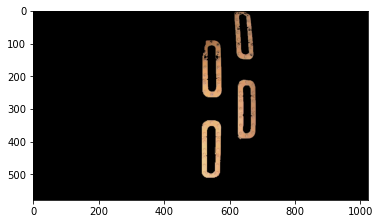

In [2]:
yy=window_level(win)
plt.imshow(yy)

In [3]:
mask=creating_mask(yy)


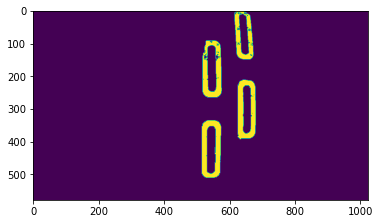

In [4]:
plt.imshow(mask)

In [5]:
mask1=process_mask(mask)


In [6]:
        #plt.imshow(mask)
r,bigw,smallw=get_big_window(mask1,win,yy)

big win [[516, 334, 65, 180], [626, 210, 65, 180], [518, 90, 65, 180], [616, 0, 65, 180]]
small win [[634, 12, 20, 140], [536, 356, 20, 140], [646, 232, 20, 140], [539, 109, 20, 140]]


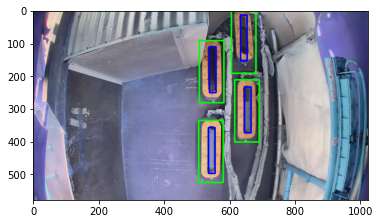

In [7]:
plt.imshow(r)